<h1>Module 16 Project - Vincent Perkins</h1>

Use the code below to help you analyze the data returned by the MBTA API:

In [207]:
mbtaURL = "https://api-v3.mbta.com/vehicles?filter[route]=1&include=trip"

import urllib.request, json
with urllib.request.urlopen(mbtaURL) as url:
    data = json.loads(url.read().decode())
   
    with open('data.json', 'w') as outfile:
        json.dump(data, outfile)
   
    with open('data.txt', 'w') as outfile:
        json.dump(json.dumps(data, indent=4, sort_keys=True), outfile)
       
    print(json.dumps(data, indent=4, sort_keys=True))


{
    "data": [],
    "jsonapi": {
        "version": "1.0"
    }
}


Use the code below to read the data from your MySQL database and store it in a pandas dataframe.  

You you need to install pymysql to run the code:

pip install pymysql

In [208]:
import os
import pymysql
import pandas as pd


host = '127.0.0.1' 
port = '3306'
user = 'localhost'
password = 'JarvinDB'
database = 'MBTAdb'

conn = pymysql.connect(
    host=host,
    port=int(3300),
    user="root",
    passwd=password,
    db=database,
    charset='utf8mb4')

df = pd.read_sql_query("SELECT * FROM mbta_buses",
    conn)

df.tail(10)

,record_num,id,latitude,longitude,label,current_status,current_stop_sequence,occupancy_status,speed,updated_at,direction_id
20424,20425,y1892,42.372950,-71.119099,1892,IN_TRANSIT_TO,2.0,MANY_SEATS_AVAILABLE,None,2022-05-29T18:51:15-04:00,1
20425,20426,y1862,42.373036,-71.117338,1862,IN_TRANSIT_TO,1.0,MANY_SEATS_AVAILABLE,None,2022-05-29T18:49:41-04:00,0
20426,20427,y1803,42.331351,-71.077217,1803,IN_TRANSIT_TO,5.0,MANY_SEATS_AVAILABLE,None,2022-05-29T18:51:09-04:00,0
20427,20428,y1788,42.329800,-71.083730,1788,IN_TRANSIT_TO,1.0,MANY_SEATS_AVAILABLE,None,2022-05-29T18:50:51-04:00,1
20428,20429,y1897,42.350701,-71.089439,1897,IN_TRANSIT_TO,14.0,FEW_SEATS_AVAILABLE,None,2022-05-29T18:51:21-04:00,0
20429,20430,y1894,42.357454,-71.092778,1894,IN_TRANSIT_TO,11.0,FEW_SEATS_AVAILABLE,None,2022-05-29T18:51:18-04:00,1
20430,20431,y1892,42.372681,-71.119173,1892,IN_TRANSIT_TO,2.0,MANY_SEATS_AVAILABLE,None,2022-05-29T18:51:23-04:00,1
20431,20432,y1862,42.373036,-71.117338,1862,IN_TRANSIT_TO,1.0,MANY_SEATS_AVAILABLE,None,2022-05-29T18:49:41-04:00,0
20432,20433,y1803,42.331345,-71.077239,1803,IN_TRANSIT_TO,5.0,MANY_SEATS_AVAILABLE,None,2022-05-29T18:51:20-04:00,0
20433,20434,y1788,42.329800,-71.083730,1788,IN_TRANSIT_TO,1.0,MANY_SEATS_AVAILABLE,None,2022-05-29T18:50:51-04:00,1



The code below saves the data as a csv file to the local directory as a backup.

In [209]:

df.to_csv('mbta.csv')

<h1>What is the average time it takes for a bus to complete the route</h1>

In reveiwing the mbta.csv file, there are 24 total stops recorded on route 1. We will calculate the total time to complete the route by subtracting time stamps of the first and last stops for each bus in a single day. 

In [210]:
#get the data from only one day and create a list of buses
df_1_day = df[df['updated_at'].str.startswith('2022-05-29')]
bus_list = df_1_day['label'].unique()
bus_list

array(['1892', '1860', '1803', '1788', '1894', '1903', '1834', '1897',
       '1751', '1862'], dtype=object)

In [211]:
#Bus is initially recorded at stop n, so we must find the next timestamp that reads n, 
#after the bus has moved from the initial stop.
from datetime import datetime

def find_route_times(): #Loops though data to find when the bus reaches stop "first_seq" again ("first_seq" dependes on where the bus starded)
    bus_times_dict = {}
    for i in range(0,len(bus_list)):    
        cur_bus = df_1_day[df_1_day['label'] == bus_list[i]] #get data for only one bus label
        seq_series = cur_bus['current_stop_sequence'] #get stop sequence data for certain bus
        first_seq = seq_series.iloc[0]
        first_rec_stop = cur_bus['updated_at'].iloc[0]
        next = False #variable to indicate if bus has reached the next stop number
        for j in range(0, len(seq_series)):
            if seq_series.iloc[j] != first_seq: 
                next = True
                #print(bus_list[i], j)
            if seq_series.iloc[j] == first_seq and next == True: #This criteria excludes buses that did not traverse the full route
                #print(f"{bus_list[i]}, Full route index loc: {j}")
                last_rec_stop = cur_bus['updated_at'].iloc[j]
                #We populate a dictionary with the difference in times between the first stop recorded and time of stop made once reaching that sequence again
                bus_times_dict[bus_list[i]] = \
                    datetime.strptime(last_rec_stop, '%Y-%m-%dT%H:%M:%S-04:00') -\
                    datetime.strptime(first_rec_stop, '%Y-%m-%dT%H:%M:%S-04:00')
                break 
    return bus_times_dict

route_times = find_route_times()
print(route_times) #Show route times for each bus


{'1892': datetime.timedelta(0, 2644), '1860': datetime.timedelta(0, 1382), '1803': datetime.timedelta(0, 2267), '1788': datetime.timedelta(0, 1384), '1894': datetime.timedelta(0, 2402), '1903': datetime.timedelta(0, 5605), '1834': datetime.timedelta(0, 2860), '1897': datetime.timedelta(0, 2563)}


In [212]:
#Calculating Average Overall Time for route
from datetime import timedelta
route_times_values = pd.Series(list(route_times.values()), index = route_times.keys())
mean_time = route_times_values.mean() 
print(f"The average time to complete route 1 is: {(mean_time / timedelta(minutes=1))} minutes.")

The average time to complete route 1 is: 43.97291666666667 minutes.


<h1>Provide a Visualization based on the data</h1>

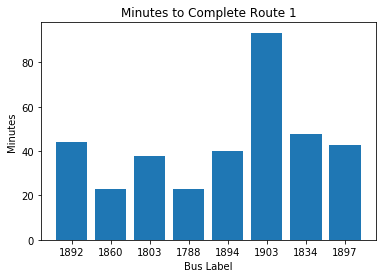

In [213]:
import matplotlib.pyplot as plt
import numpy as np
route_times_float = route_times_values / timedelta(minutes=1)
bus_list_r = list(route_times.keys())
#times = list(route_times.values())
plt.bar(bus_list_r, route_times_float)
plt.title('Minutes to Complete Route 1')
plt.xlabel('Bus Label')
plt.ylabel('Minutes')
plt.show()

<h1>Give an estimate of the speed of the bus from current_stop_sequence = 1 to the last  current_stop_sequence. </h1> 

Note: You can use the haversine Python library to calculate the distance between two points, given two longitude and latitude coordinates.

In [214]:
#Bus 1903 started on stop 1 on 05-29-2022. We will calculate it's speed.

from haversine import haversine
def route_end_index(): #Loops though data to find when the bus reaches stop "first_seq" again. 
    route_end_dict = {}
    for i in range(0,len(bus_list)):    
        cur_bus = df_1_day[df_1_day['label'] == bus_list[i]] #get data for only one bus label
        seq_series = cur_bus['current_stop_sequence'] #get stop sequence data for certain bus
        first_seq = seq_series.iloc[0]
        first_rec_stop = cur_bus['updated_at'].iloc[0]
        next = False #variable to indicate if bus has reached the next stop number
        for j in range(0, len(seq_series)):
            if seq_series.iloc[j] != first_seq: 
                next = True
                #print(bus_list[i], j)
            if seq_series.iloc[j] == first_seq and next == True: #This criteria excludes buses that did not traverse the full route
                #We populate a dictionary with the index of the last stop on the route
                route_end_dict[bus_list[i]] = j - 1
                break 
    return route_end_dict

bus_df =  df_1_day[df_1_day['label'] == '1903'] #Dataframe for bus label 1903
route_start = bus_df.iloc[1] #start
route_end = bus_df.iloc[route_end_index()['1903']] 
route_times_valuesf = route_times_values / timedelta(hours = 1)
route_time = route_times_valuesf['1903']

start_loc = tuple(route_start[['latitude','longitude']])
end_loc = tuple(route_end[['latitude','longitude']])

distance = haversine(start_loc, end_loc) #km

route_speed = distance/route_time
print(f"The estimated route speed for bus 1903 was {route_speed} km/h")

The estimated route speed for bus 1903 was 3.845633576401702 km/h


In [215]:
#test = df_1_day[df_1_day['label'] == '1903'][['current_stop_sequence', 'updated_at','latitude', 'longitude', 'direction_id']]
#test.to_csv("test.csv")